#Bank Marketing Machine Learning

Nous allons chercher à prédire si un utilisateur est suceptible de souscrire au produit mis en avant par la campagne marketing.

In [601]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

##Datas

bank client data: 45211 lignes

1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")
related with the last contact of the current campaign:

9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)
other attributes:

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):

17 - y: has the client subscribed a term deposit? (binary: "yes","no")

In [602]:
#https://www.kaggle.com/sonujha090/bank-marketing
df = pd.read_csv('bank-full.csv')

numerics = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cats = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
bools = ['default', 'housing', 'loan', 'y']

print(df.shape)

(45211, 17)


##DataViz

In [603]:
#Fonction d'affichage du piechart s'une colonne
def show_piechart(col):
  df[col]
  df_tmp = pd.DataFrame()
  df_tmp[col] = df[col]
  df_tmp['count'] = df[col]
  df_tmp = df_tmp.groupby(by=col).count()
  fig1, ax1 = plt.subplots()
  ax1.pie(df_tmp['count'], labels=df_tmp.index, autopct='%1.1f%%', shadow=True, startangle=0)
  ax1.axis('equal')
  plt.title(col)
  plt.show()

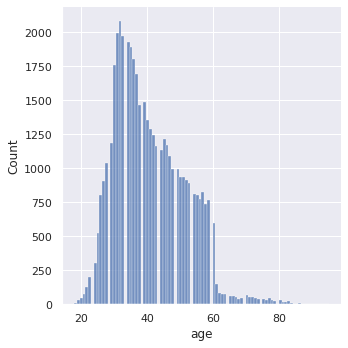

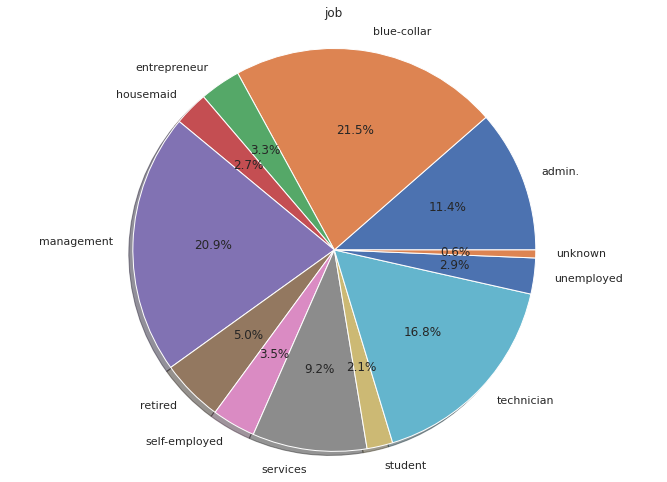

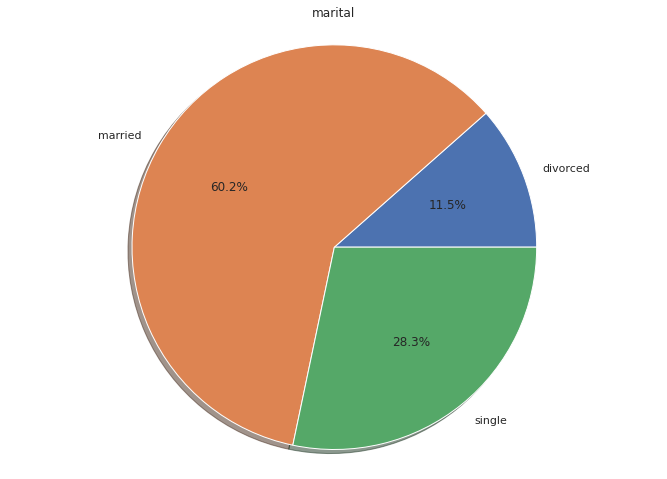

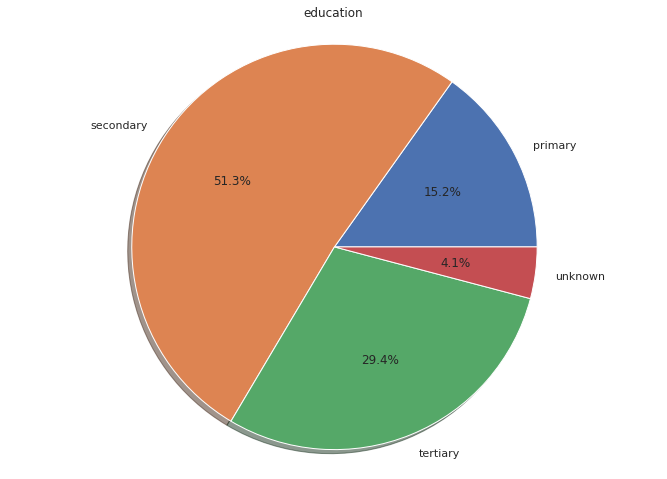

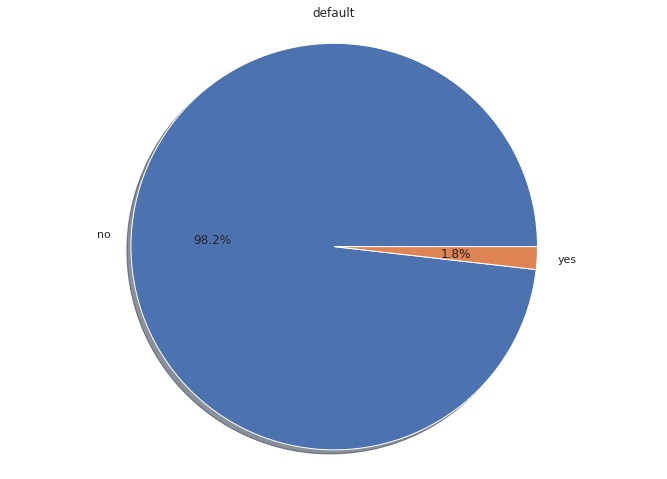

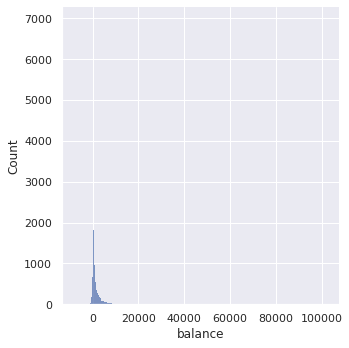

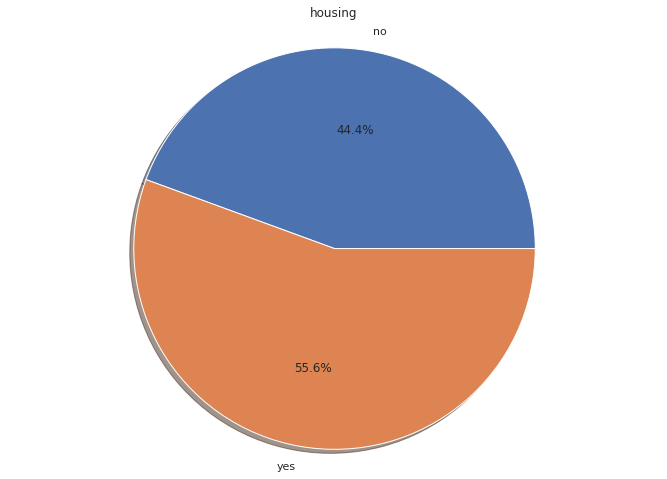

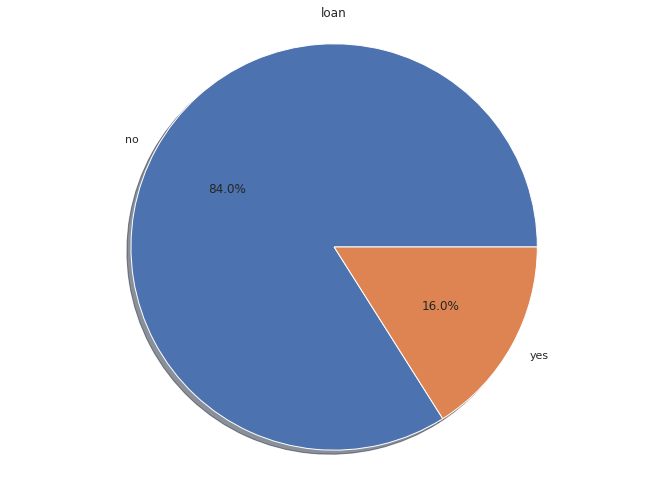

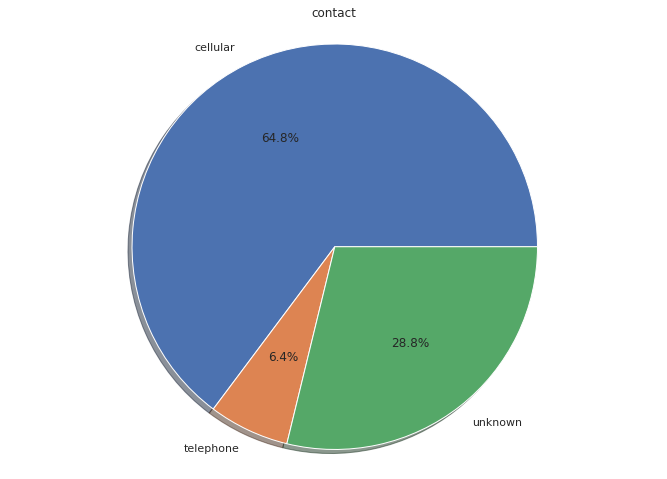

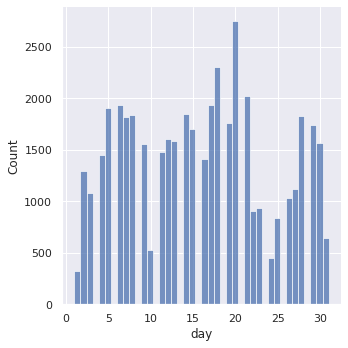

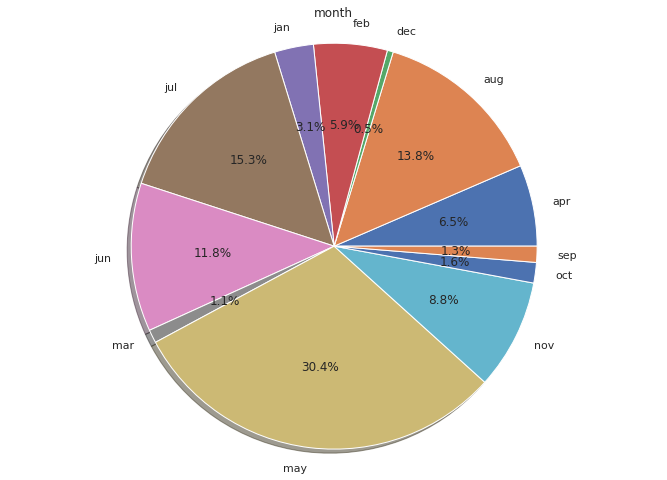

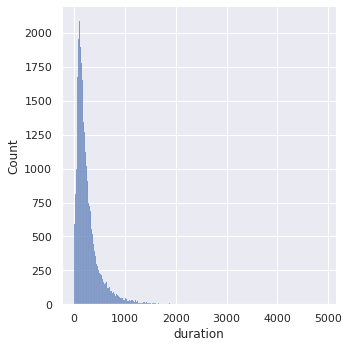

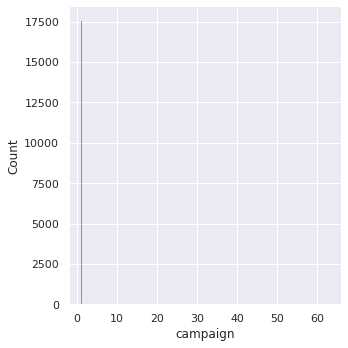

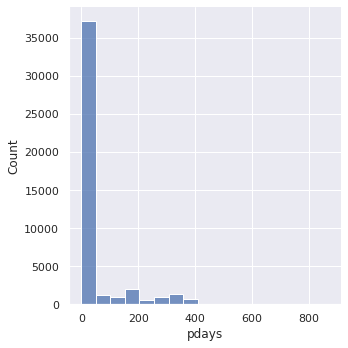

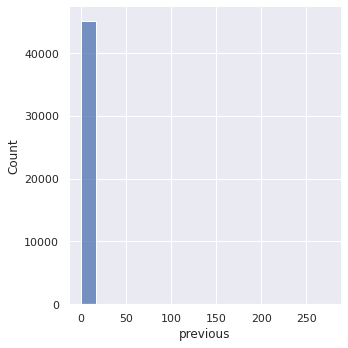

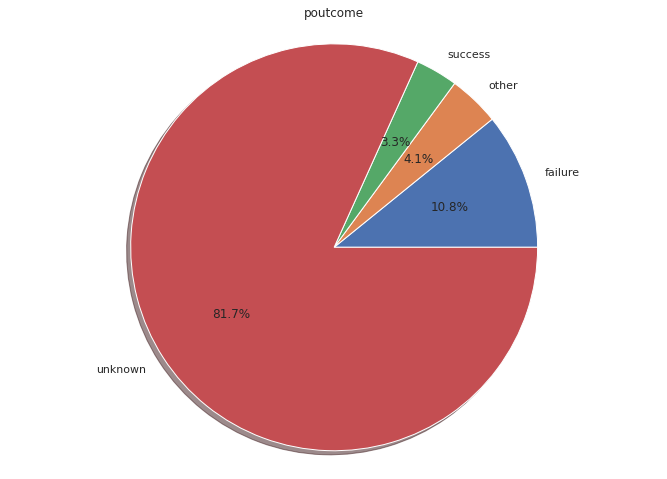

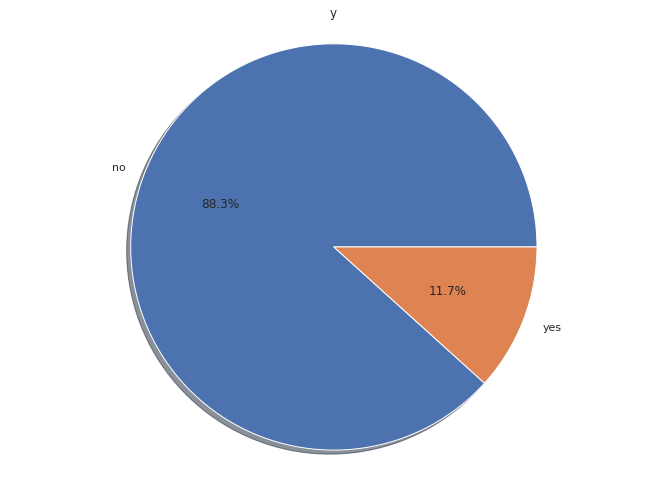

In [604]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

#Distplots (type gaussienne) & piechart pour les catégories
for each in df.columns:
  if each in numerics:
    sns.displot(df[each])
  else:
    show_piechart(each)

Pour la feature job, les catégories suivantes représentent moins de 3% :
unknow, unemployed, housemaid, student

Pour les mois cela ne semble pas pertinent de les regroupés



In [605]:
for each in numerics:
  print(df[each].describe())
  print()

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

count    45211.000000
mean        15.806419
std          8.322476
min          1.000000
25%          8.000000
50%         16.000000
75%         21.000000
max         31.000000
Name: day, dtype: float64

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.00

On remarque que certains individus ont un compte en banque avec une valeur négative, dépendament du produit proposé par la campagne, ces individus pourrait être écartés.

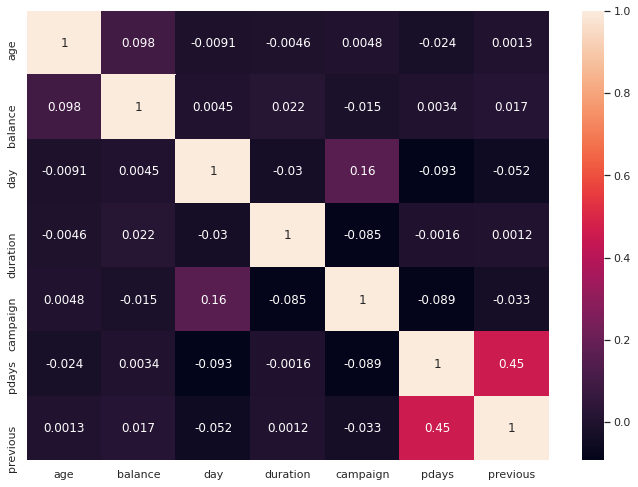

In [606]:
#Heatmap:
sns.heatmap(df.corr(), annot=True)

La seule correlation notable est celle entre pdays et previous:

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

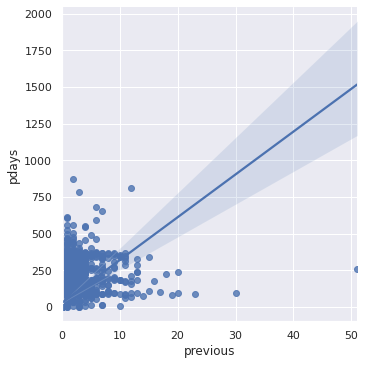

In [607]:
sns.lmplot(y="pdays", x="previous", data=df.sample(5000).query('previous < 75'))

Relation entre les deux features les plus correlées.

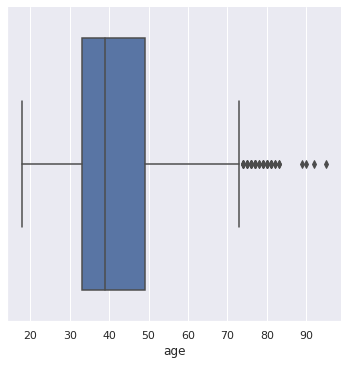

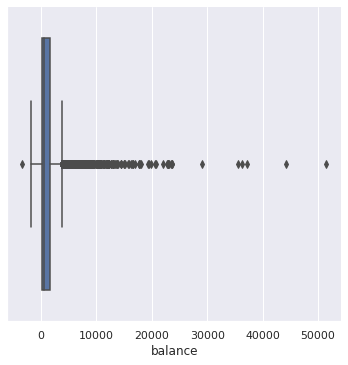

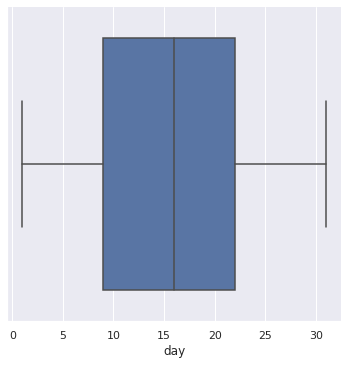

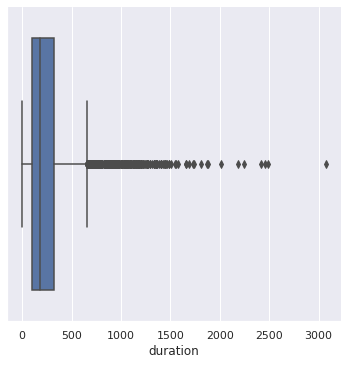

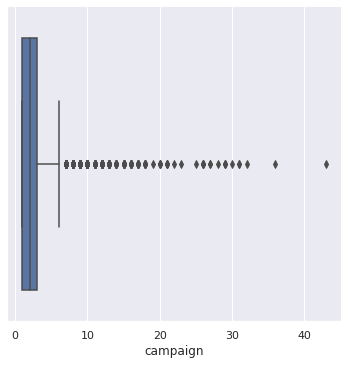

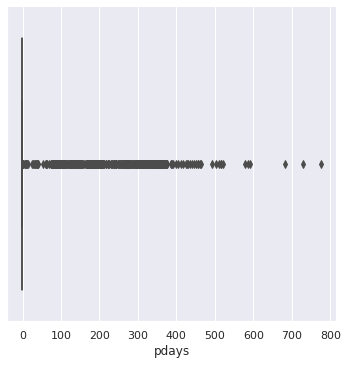

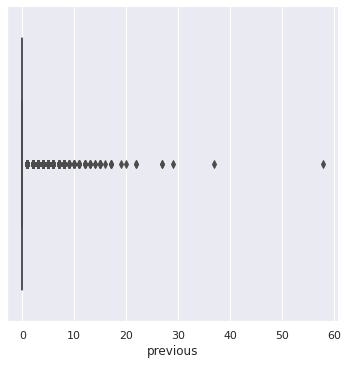

In [608]:
#Données extremes : boites a moustaches
for each in numerics:
  g = sns.catplot(x=each, data=df.sample(5000), kind='box')

Valeurs extrêmes ...

##Features Engineering

In [609]:
#Verification des valeurs nulles
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [610]:
#oneHot encoding en parler, relevant for job, marital, education
# <=> dummies

In [611]:
encoders = {}
for each in cats:
  le = LabelEncoder()
  le.fit(df[each])
  print('{}: {}'.format(each, le.classes_))
  df[each] = le.transform(df[each])
  #le.inverse_transform(df[each])
  encoders[each] = le

job: ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
marital: ['divorced' 'married' 'single']
education: ['primary' 'secondary' 'tertiary' 'unknown']
contact: ['cellular' 'telephone' 'unknown']
month: ['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
poutcome: ['failure' 'other' 'success' 'unknown']


In [612]:
for each in bools:
  df[each] = df[each].apply(lambda x: 1 if x == 'yes' else 0)

##Model Building

In [613]:
target = df['y']
features = df.copy().drop(columns=['y'])

In [614]:
#TTS
X_tr, X_te, Y_tr, Y_te = train_test_split(features, target)

In [615]:
#Pipeline LinearSVC #a faire pour KNN puis SVC selon le workflow
#pipeline_details = [('LinearSVC', LinearSVC())]
#pipeline = Pipeline(steps=pipeline_details)

#pipeline_details = [('KNN', KNeighborsClassifier())]
#pipeline = Pipeline(steps=pipeline_details)

#pipeline_details = [('SVC', SVC())]
#pipeline = Pipeline(steps=pipeline_details)

#pipeline_details = [('LR', LogisticRegression())]
#pipeline = Pipeline(steps=pipeline_details)

In [616]:
hyperparameters = {}
#hyperparameters['LinearSVC__loss'] = ['hinge', 'squared_hinge']
#hyperparameters['LinearSVC__max_iter'] = [2500]
#hyperparameters['LinearSVC__C'] = list(range(1, 10, 1))
#LinearSVC: tol ? C ? penalty ? class_weight ? max_iter ?

#hyperparameters['KNN__n_neighbors'] = [i for i in range(1, 15 +1, 2)]

#hyperparameters['SVC__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

#hyperparameters['LR__C'] = list(range(1, 10, 1))
#hyperparameters['LR__max_iter'] = list(range(1000, 10001, 1000))

#hyperparameters['DT__max_depth'] = list(range(1, 11, 1))

In [617]:
#hyperparameter_search = GridSearchCV(pipeline,
#                                     hyperparameters,
#                                     scoring='accuracy',
#                                     cv=5)
#scoring a developper

In [618]:
#hyperparameter_search.fit(X_tr, Y_tr)

#print('Meilleur score : {:.5f}'.format(hyperparameter_search.best_score_))
#print('Meilleur paramètres : {}'.format(hyperparameter_search.best_params_))

In [619]:
#Affichage des coefficients/ accuracy
def accuracy(p, y):
  return (p==y).sum()/len(y)

def show_cm(cm, labels):
    """show confusion matrix
    """
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

def show_roc(n_classes, Y_te, proba):
  n_classes = 2
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(Y_te, proba[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  fpr["micro"], tpr["micro"], _ = roc_curve(Y_te.ravel(), proba[:, i].ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  plt.figure()
  lw = 2
  plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

  if n_classes > 2:
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [620]:
#algo1:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_tr, Y_tr)

preds = knn.predict(X_te)
proba = knn.predict_proba(X_te)

result_df = pd.DataFrame(X_te.copy())
result_df['Predictions'] = preds
for i in range(0, len(proba[0])):
  result_df['Probability'] = proba[:, (0 if preds[i] == 0 else 1)]

Accuracy: 0.8850747589135628


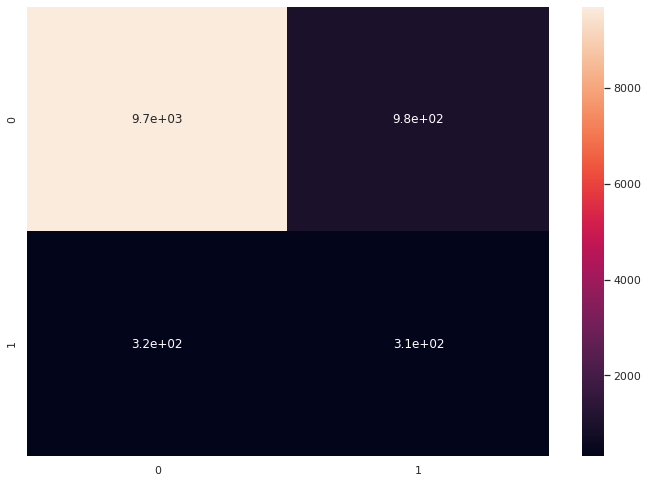

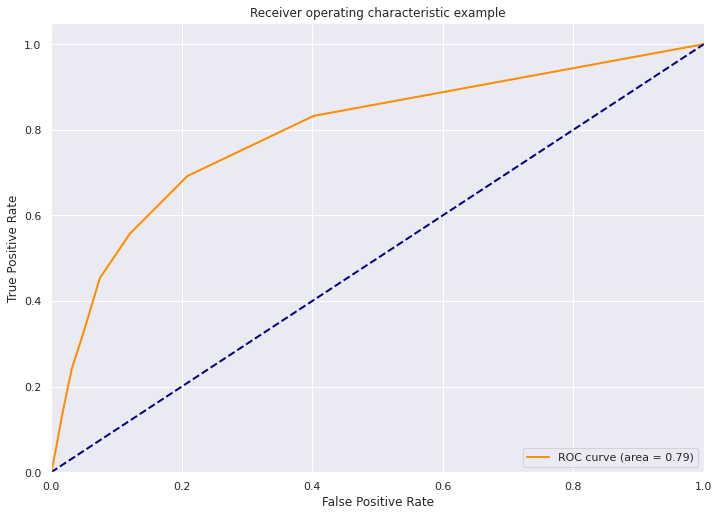

In [621]:
print('Accuracy: {}'.format(accuracy(preds, Y_te)))
show_cm(confusion_matrix(preds, Y_te, labels=[0, 1]), [0, 1])
show_roc(2, Y_te, proba)

In [622]:
#algo2:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_tr, Y_tr)

preds = rf.predict(X_te)
proba = rf.predict_proba(X_te)

result_df = pd.DataFrame(X_te.copy())
result_df['Predictions'] = preds
for i in range(0, len(proba[0])):
  result_df['Probability'] = proba[:, (0 if preds[i] == 0 else 1)]

Accuracy: 0.9035654251083783


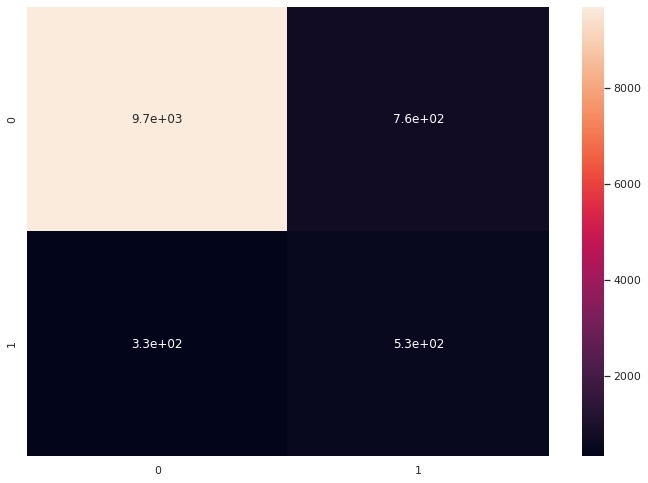

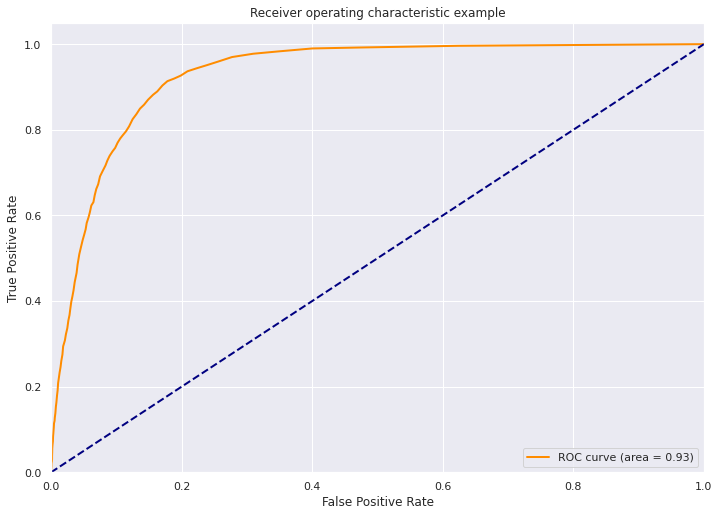

In [623]:
print('Accuracy: {}'.format(accuracy(preds, Y_te)))
show_cm(confusion_matrix(preds, Y_te, labels=[0, 1]), [0, 1])
show_roc(2, Y_te, proba)

In [624]:
#algo3:
dt = DecisionTreeClassifier()
dt.fit(X_tr, Y_tr)

preds = dt.predict(X_te)
proba = dt.predict_proba(X_te)

result_df = pd.DataFrame(X_te.copy())
result_df['Predictions'] = preds
for i in range(0, len(proba[0])):
  result_df['Probability'] = proba[:, (0 if preds[i] == 0 else 1)]

Accuracy: 0.873838803857383


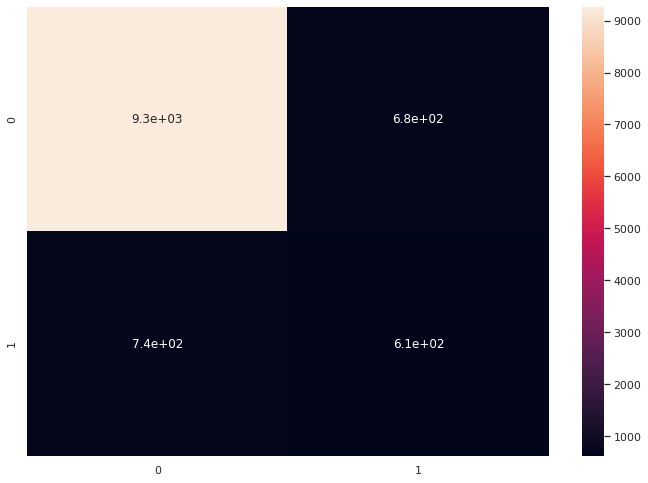

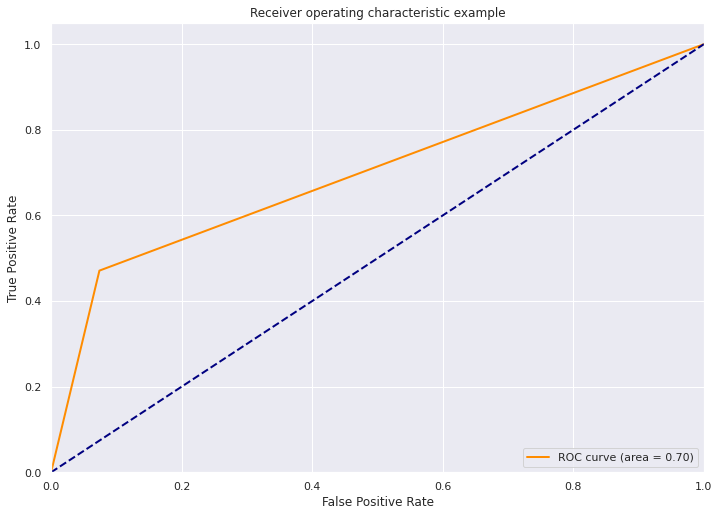

In [625]:
print('Accuracy: {}'.format(accuracy(preds, Y_te)))
show_cm(confusion_matrix(preds, Y_te, labels=[0, 1]), [0, 1])
show_roc(2, Y_te, proba)

##Pouvoir prédictif des features

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


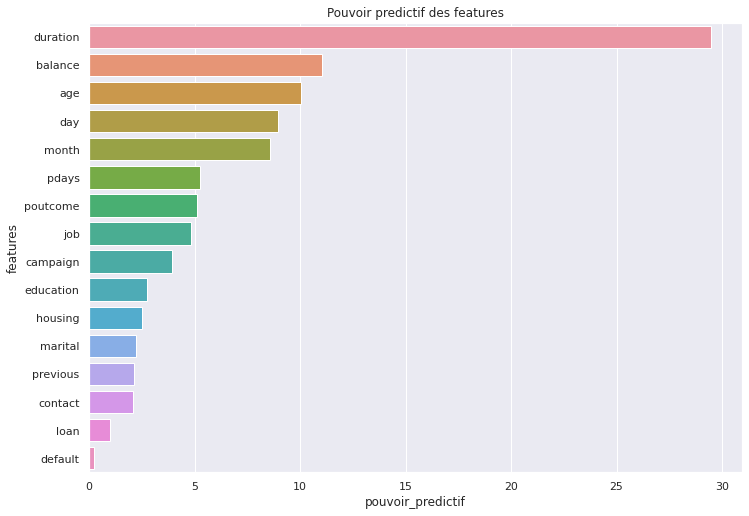

In [626]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_tr, Y_tr)
importances = rf.feature_importances_
d = pd.DataFrame()
d['features'] = X_tr.columns
d['pouvoir_predictif'] = importances
d['pouvoir_predictif'] = d['pouvoir_predictif'].apply(lambda v : v*100)
d = d.sort_values(by='pouvoir_predictif', ascending=False)
sns.barplot(d['pouvoir_predictif'], d['features']).set_title('Pouvoir predictif des features');

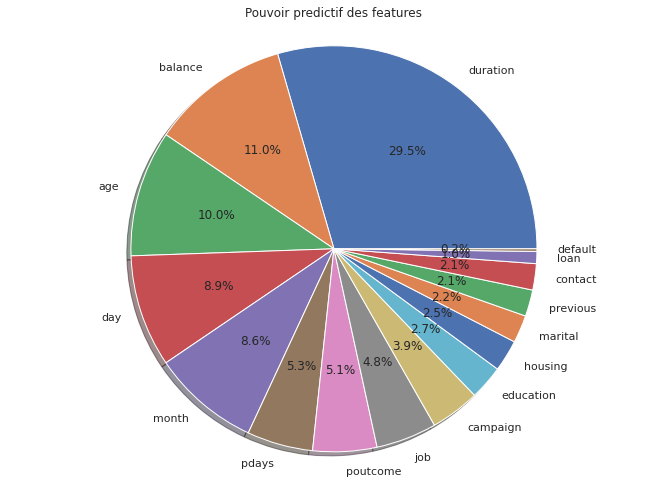

In [627]:
fig1, ax1 = plt.subplots()
ax1.pie(d['pouvoir_predictif'], labels=d['features'], autopct='%1.1f%%', shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pouvoir predictif des features')
plt.show()

##Choix du modèle

In [628]:
model = rf

##Choix des features

In [629]:
#Duration
#Balance
#Age

#Day et Month représentent 17.3% du pouvoir prédictif, hors ...

#Poutcome
#Pdays
#Job
#Campaign
#Education
#Housing
#Marital